# Albedo

The objective of this script is to calculate the albedo of the desert background and the PV field based on the March 2018 campaign, due to the proper location of the mast radiation sensors in this campaign. This albedo will be considered for the other campaigns as well, assuming that the albedo does not change with the seasons in these surfaces.

In [1]:
import pandas as pd
import openpyxl
import numpy as np
import glob
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
from plotnine.data import mtcars
import scipy.stats
from scipy import signal
from scipy import stats

### Input and output paths

In [2]:
project_path = 'D:/Users/Rafaels/Dropbox/Doutorado/Working/Ketura/'   # Weizmann desktop
#project_path = 'C:/Users/rafas/Dropbox/Doutorado/Working/Ketura/'     # notebook
input_path   = project_path + '01_data/'
output_path  = project_path + '02_output/'
graphs_path  = project_path + '03_graphs/'

## Functions

In [3]:
# Loads all data in the folder
def load_all_data(path):
    file_list = sorted(glob.glob(path + '*corr.csv', recursive=True))

    data_list = []
    for filename in file_list:
        fn_without_path = filename.replace(path[:-1], "")[1:]
        print("Loading", fn_without_path)
        
        temp = pd.read_csv(filename)
        temp['DateTime'] = pd.to_datetime(temp['DateTime'], format='%Y-%m-%d %H:%M:%S', utc=True)
       
        temp.loc[temp['Month'] == 'July', 'Season'] = 'Summer'
        temp.loc[temp['Month'] == 'August', 'Season'] = 'Summer'
        temp.loc[temp['Month'] == 'October', 'Season'] = 'Autumn'
        temp.loc[temp['Month'] == 'March', 'Season'] = 'Spring'
        temp.loc[temp['Ecosystem'] == 'Solar', 'Ecosystem'] = 'PV field'
        temp.loc[temp['Ecosystem'] == 'Desert', 'Ecosystem'] = 'Desert background'
        temp.loc[temp['Ecosystem'] == 'Yatir', 'Ecosystem'] = 'Yatir desert'
    
        data_list.append(temp)
    
    # Combine all the read data
    df = pd.concat(data_list, axis=0, ignore_index=True)
    
    # Rename
    df.rename(columns={'SW_OUT_average': 'Sout'}, inplace=True)
    df.rename(columns={'SW_IN_average': 'Sin'}, inplace=True)
    df.rename(columns={'PPFD_IN_0_0_1': 'PARin'}, inplace=True)
    df.rename(columns={'PPFD_OUT_0_0_1': 'PARout'}, inplace=True)

       
    # Convert columns to float
    df['Sout']  = pd.to_numeric(df['Sout'], downcast="float")
    df['Sin']  = pd.to_numeric(df['Sin'], downcast="float")
    df['PARout']  = pd.to_numeric(df['PARout'], downcast="float")
    df['PARin']  = pd.to_numeric(df['PARin'], downcast="float")
    
    df['albedo'] = df['Sout']/df['Sin']
    df['albedo_PAR'] = df['PARout']/df['PARin']
    
    # define mid-day
    #df = df.loc[(df['DateTime'].dt.hour >= 10) & (df['DateTime'].dt.hour < 15)].copy() 
    df = df.loc[(df['Season'] == 'Spring')].copy() 
    
    # Keep only relevant columns
    df = df[['DateTime','Season','Year','Ecosystem','Sin','Sout','albedo','albedo_PAR']]
    

    return(df)


def diurnal(temp):
    temp = temp.copy()
    
    # creating 'Time' column
    temp['Time'] = temp['DateTime'].dt.strftime('%H:%M')
    
    # Keep only relevant columns
    temp = temp[['Time','Ecosystem','Season','albedo','Sin']]
    
    # Make mean and std dev
    df_grouped = temp.groupby(['Ecosystem','Season','Time']).agg(['mean','std']).reset_index()
    df_grouped.columns = ['_'.join(col).strip('_') for col in df_grouped.columns.values]
    
    return(df_grouped)


def albedo_daily(temp):
    temp = temp.copy()
    
    # creating 'Day' column
    temp['Day'] = temp['DateTime'].dt.strftime('%Y-%m-%d')
    
    # Keep only relevant columns
    temp = temp[['Day','Ecosystem','Season','Sin','Sout']]
    daily_df = temp.groupby(['Day','Ecosystem','Season']).sum()
    daily_df.reset_index(inplace=True)
    
    daily_df['albedo_day'] = daily_df['Sout']/daily_df['Sin']
    
    daily_df = daily_df.loc[daily_df['Sin'] > 100]
    out_df = daily_df[['Ecosystem','Season','albedo_day']].groupby(['Ecosystem','Season']).agg(['mean','std']).reset_index()
    out_df.columns = ['_'.join(col).strip('_') for col in out_df.columns.values]
    
    display(daily_df)
      
    return(out_df)



def albedo_seasonal(temp):
    
    # define mid-day
    temp = temp.loc[(temp['DateTime'].dt.hour >= 10) & (temp['DateTime'].dt.hour < 15)].copy() 

    # Make mean and std dev
    df_means = temp.groupby(['Ecosystem','Season',]).mean().reset_index()
    df_sds   = temp.groupby(['Ecosystem','Season',]).std().reset_index()
    # rename columns
    df_means.rename(columns={'albedo': 'albedo_mean'}, inplace=True)
    df_means.rename(columns={'albedo_PAR': 'albedo_PAR_mean'}, inplace=True)
    
    df_sds.rename(columns={'albedo': 'albedo_sd'}, inplace=True)
    df_sds.rename(columns={'albedo_PAR': 'albedo_PAR_sd'}, inplace=True)
    
    merged = df_means.merge(df_sds, on=['Ecosystem','Season'])
    
    # Keep only relevant columns
    merged = merged[['Season','Ecosystem','albedo_mean','albedo_sd','albedo_PAR_mean','albedo_PAR_sd']]    
    
    return(merged)

def pvalue_text(p):
    if(p <= 0.001): p_text = '<.001'
    if(p > 0.001): p_text = '<.01'
    if(p > 0.01): p_text = '<.05'
    if(p > 0.05): p_text = p.round(2).astype(str)
    return(p_text)

def load_tower(fn, silent=False):
    if (not silent): print('EC Tower')
    temp = pd.read_csv(fn, index_col=None)
    temp.rename({'date_mid_hour': 'DateTime'}, axis=1, inplace=True)
    temp['DateTime'] = pd.to_datetime(temp['DateTime'], format='%d%b%y:%H:%M', utc=True)
    # Remove obsolete columns
    temp.drop(['year','date','DOY','month','weekNo','mid_hour','mmyy','Bat_V','Hum_AC'], axis=1, inplace=True)
    if (not silent): print("    ", '100.0 %\t', fn.split('/')[-1])
    return(temp)

In [4]:
spring_df = load_all_data(input_path)

# Remove the bad 22nd of march 2018
spring_df = spring_df.loc[(spring_df['Season'] == 'Spring') & (spring_df['DateTime'].dt.day != 22)].copy() 
#display(spring_df.loc[(spring_df['Season'] == 'Summer')])

display (spring_df)

Loading Ketura_all_corr.csv
Loading Yatir_desert_all_corr.csv


,DateTime,Season,Year,Ecosystem,Sin,Sout,albedo,albedo_PAR
286,2018-03-18 18:30:00+00:00,Spring,2018,Desert background,0.000000,0.000000,NaN,0.036287
287,2018-03-18 19:00:00+00:00,Spring,2018,Desert background,0.000000,0.000000,NaN,0.054446
288,2018-03-18 19:30:00+00:00,Spring,2018,Desert background,0.000000,0.013073,inf,0.021913
289,2018-03-18 20:00:00+00:00,Spring,2018,Desert background,0.000000,0.054669,inf,0.040109
290,2018-03-18 20:30:00+00:00,Spring,2018,Desert background,0.000000,0.023955,inf,0.045303
...,...,...,...,...,...,...,...,...
1466,2018-03-27 14:00:00+00:00,Spring,2018,PV field,209.371002,52.897598,0.252650,0.232436
1467,2018-03-27 14:30:00+00:00,Spring,2018,PV field,295.250000,73.720299,0.249688,0.227634
1468,2018-03-27 15:00:00+00:00,Spring,2018,PV field,300.312012,74.390602,0.247711,0.226316
1469,2018-03-27 15:30:00+00:00,Spring,2018,PV field,237.809952,69.146744,0.290765,NaN


In [5]:
spring_df_daily_albedo = albedo_daily(spring_df).round(2)

display(spring_df_daily_albedo)

,Day,Ecosystem,Season,Sin,Sout,albedo_day
1,2018-03-19,Desert background,Spring,13726.262695,5502.404297,0.400867
2,2018-03-20,Desert background,Spring,12651.514648,5090.398926,0.402355
3,2018-03-21,Desert background,Spring,14001.200195,5628.659180,0.402013
4,2018-03-23,PV field,Spring,11602.200195,2649.152100,0.228332
5,2018-03-24,PV field,Spring,10509.062500,2443.979004,0.232559
6,2018-03-25,PV field,Spring,13042.171875,3009.865234,0.230779
7,2018-03-26,PV field,Spring,12928.525391,3062.115234,0.236850
8,2018-03-27,PV field,Spring,6753.620605,1722.451538,0.255041


,Ecosystem,Season,albedo_day_mean,albedo_day_std
0,Desert background,Spring,0.40,0.00
1,PV field,Spring,0.24,0.01


In [6]:
diurnal_cycle_df = diurnal(spring_df)
# re-order categories
diurnal_cycle_df['Season'] = pd.Categorical(diurnal_cycle_df['Season'], ordered=True, categories=['Spring','Summer','Autumn'])
diurnal_cycle_df.loc[~np.isfinite(diurnal_cycle_df['albedo_mean']), 'albedo_mean'] = 0
diurnal_cycle_df.loc[(diurnal_cycle_df['albedo_mean']) > 1, 'albedo_mean'] = 0
diurnal_cycle_df.loc[(diurnal_cycle_df['albedo_std']) > 1, 'albedo_std'] = 0

display (diurnal_cycle_df)

,Ecosystem,Season,Time,albedo_mean,albedo_std,Sin_mean,Sin_std
0,Desert background,Spring,00:00,0.0,NaN,0.000000,0.000000
1,Desert background,Spring,00:30,0.0,NaN,0.000000,0.000000
2,Desert background,Spring,01:00,0.0,NaN,0.000000,0.000000
3,Desert background,Spring,01:30,0.0,NaN,0.000000,0.000000
4,Desert background,Spring,02:00,0.0,NaN,0.000000,0.000000
...,...,...,...,...,...,...,...
91,PV field,Spring,21:30,0.0,NaN,0.002213,0.004426
92,PV field,Spring,22:00,0.0,NaN,0.001297,0.002595
93,PV field,Spring,22:30,0.0,NaN,0.001706,0.003412
94,PV field,Spring,23:00,0.0,NaN,0.000180,0.000360


C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 15.0 x 10.0 cm image.
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: D:/Users/Rafaels/Dropbox/Doutorado/Working/Ketura/03_graphs/albedo_diurnal.pdf
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 15.0 x 10.0 cm image.
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: D:/Users/Rafaels/Dropbox/Doutorado/Working/Ketura/03_graphs/albedo_diurnal.png


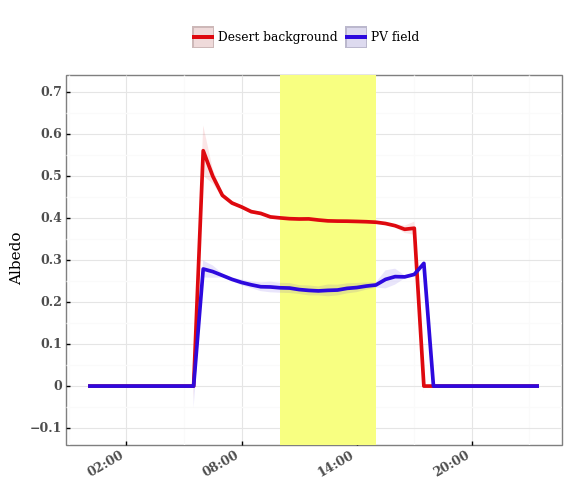

<ggplot: (-9223371989656413840)>

In [9]:
cbPalette = ["#DE090F","#2D09DE", "#DE090F", "#02000B", "#c2c2d6", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

# Convert the times back to a “fake” timestamp:
diurnal_cycle_df['timestamp2'] = pd.to_datetime(diurnal_cycle_df['Time'], utc=True)
# Clean night spikes
diurnal_cycle_df.loc[(diurnal_cycle_df['Sin_mean']) < 10, 'albedo_mean'] = 0

plt = ggplot(diurnal_cycle_df)
plt = plt + geom_rect(mapping=aes(xmin=np.datetime64('2022-08-29 10:00'), xmax=np.datetime64('2022-08-29 15:00'), ymax=1, ymin=-0.2), size=0, fill='#F8FF81')
plt = plt + geom_line(aes(x='timestamp2', y='albedo_mean', color='Ecosystem'),size=1.5)
#plt = plt + geom_line(aes(x='timestamp2', y='Sin_mean',linetype='Ecosystem'), colour='#234566')
plt = plt + geom_ribbon(aes(x='timestamp2', ymin='albedo_mean - albedo_std', ymax='albedo_mean + albedo_std', fill='Ecosystem'), alpha=0.1)
plt = plt + labs(x='Hour', y='Albedo', parse=True)
#plt = plt + facet_wrap(['Ecosystem'])
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + theme(axis_text_x=element_text(size=9,rotation=30,hjust=1,weight='bold'),
                  axis_title_x = element_blank(),
                  axis_text_y=element_text(size=9,weight='bold'),
                  strip_text=element_text(size=9,weight='bold'),
                  legend_title=element_blank(),
                  text=element_text(family="serif"), axis_ticks_direction_y='in', axis_ticks_direction_x='in')
plt = plt + theme(legend_position = 'top')
plt = plt + coord_cartesian(ylim=(-0.1, 0.7))
plt = plt + scale_y_continuous(breaks=np.arange(-0.1, 1, 0.1))
plt = plt + scale_x_datetime(date_breaks = '6 hours', date_labels = '%H:%M')

plt.save(graphs_path + 'albedo_diurnal.pdf', width=15, height=10, units='cm', dpi=600)
plt.save(graphs_path + 'albedo_diurnal.png', width=15, height=10, units='cm', dpi=600)


plt

# t-tests

In [8]:
spring_df = spring_df.loc[(spring_df['DateTime'].dt.hour >= 10) & (spring_df['DateTime'].dt.hour < 15)].copy() 

a = spring_df.loc[(spring_df['Ecosystem'] == 'Desert background'),'albedo']
b = spring_df.loc[(spring_df['Ecosystem'] == 'PV field'),'albedo']
t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
print('P =', t[1])
p_albedo = t[1]

P = 7.981609908414806e-70


In [9]:
# a = spring_df.loc[(spring_df['Ecosystem'] == 'Desert background'),'albedo_PAR']
# b = spring_df.loc[(spring_df['Ecosystem'] == 'PV field'),'albedo_PAR']
# t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
# print('P =', t[1])

In [10]:
df_seasonal = albedo_seasonal(spring_df)

display(df_seasonal)

,Season,Ecosystem,albedo_mean,albedo_sd,albedo_PAR_mean,albedo_PAR_sd
0,Spring,Desert background,0.395215,0.003301,0.343277,0.004980
1,Spring,PV field,0.231342,0.011081,0.204347,0.012768


## Loading Yatir data

In [11]:
yatir_df = load_tower(input_path + 'Yatir_2000-2020.csv')
yatir_df['Year'] = yatir_df['DateTime'].dt.year
#yatir_df = yatir_df.loc[(yatir_df['DateTime'].dt.year >= 2015)].copy()
yatir_df = yatir_df.dropna(subset = ['S_top_atm(CM21_IV)_Wm-2','S_top_eco(CM21_III)_Wm-2'])

# Rename
yatir_df.rename(columns={'S_top_atm(CM21_IV)_Wm-2': 'Sin'}, inplace=True)
yatir_df.rename(columns={'S_top_eco(CM21_III)_Wm-2': 'Sout'}, inplace=True)


# yatir_df['DateTime'] = pd.to_datetime(yatir_df['DateTime'], format='%Y-%m-%d %H:%M:%S', utc=True)

# Convert columns to float
yatir_df['Sin']  = pd.to_numeric(yatir_df['Sin'], downcast='float')
yatir_df['Sout']  = pd.to_numeric(yatir_df['Sout'], downcast='float')

# Calculate albedo
yatir_df['albedo'] = yatir_df['Sout']/yatir_df['Sin']

# define mid-day
yatir_df = yatir_df.loc[(yatir_df['DateTime'].dt.hour >= 10) & (yatir_df['DateTime'].dt.hour < 15)].copy() 

yatir_df['Season'] = 'Spring'
yatir_df['Ecosystem'] = 'Yatir'


# Keep only relevant columns
yatir_df = yatir_df[['DateTime','Season','Year','Ecosystem','Sin','Sout','albedo']]


#print(yatir_df.columns.values)
display(yatir_df)

EC Tower


C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (9,10) have mixed types.Specify dtype option on import or set low_memory=False.


     100.0 %	 Yatir_2000-2020.csv


,DateTime,Season,Year,Ecosystem,Sin,Sout,albedo
30788,2002-02-01 10:15:00+00:00,Spring,2002,Yatir,660.500000,80.900002,0.122483
30789,2002-02-01 10:45:00+00:00,Spring,2002,Yatir,719.000000,90.500000,0.125869
30790,2002-02-01 11:15:00+00:00,Spring,2002,Yatir,755.000000,95.500000,0.126490
30791,2002-02-01 11:45:00+00:00,Spring,2002,Yatir,775.000000,97.699997,0.126065
30792,2002-02-01 12:15:00+00:00,Spring,2002,Yatir,777.000000,98.500000,0.126770
...,...,...,...,...,...,...,...
357961,2020-09-30 12:45:00+00:00,Spring,2020,Yatir,787.299988,92.000000,0.116855
357962,2020-09-30 13:15:00+00:00,Spring,2020,Yatir,741.299988,85.599998,0.115473
357963,2020-09-30 13:45:00+00:00,Spring,2020,Yatir,669.500000,77.900002,0.116355
357964,2020-09-30 14:15:00+00:00,Spring,2020,Yatir,588.400024,70.099998,0.119137


In [12]:
temp = yatir_df.copy()
temp['DateTime'] = temp['DateTime'] - pd.Timedelta(minutes=15)

all_df = pd.concat([spring_df, yatir_df])

#display(all_df)

print('Mean albedo Yatir: ', np.round(np.mean(all_df.loc[all_df['Ecosystem'] == 'Yatir', 'albedo']),2), '±', np.round(np.std(all_df.loc[all_df['Ecosystem'] == 'Yatir', 'albedo']),2))
print('Mean albedo PV:    ', np.round(np.mean(all_df.loc[all_df['Ecosystem'] == 'PV field', 'albedo']),2), '±', np.round(np.std(all_df.loc[all_df['Ecosystem'] == 'PV field', 'albedo']),2))
print('Mean albedo desert:', np.round(np.mean(all_df.loc[all_df['Ecosystem'] == 'Desert background', 'albedo']),2), '±', np.round(np.std(all_df.loc[all_df['Ecosystem'] == 'Desert background', 'albedo']),2))



Mean albedo Yatir:  0.12 ± 0.01
Mean albedo PV:     0.23 ± 0.01
Mean albedo desert: 0.4 ± 0.0


# Graph

C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 15.0 x 10.0 cm image.
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: D:/Users/Rafaels/Dropbox/Doutorado/Working/Ketura/03_graphs/albedo_ketura_yatir.pdf
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 15.0 x 10.0 cm image.
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: D:/Users/Rafaels/Dropbox/Doutorado/Working/Ketura/03_graphs/albedo_ketura_yatir.png


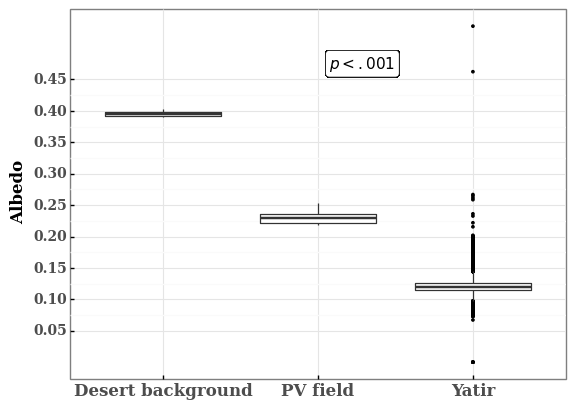

<ggplot: (-9223371992529753640)>

In [13]:
plt = ggplot(all_df)
plt = plt + theme_bw()
plt = plt + geom_boxplot(aes(x='Ecosystem', y='albedo'), outlier_color='black', outlier_size=0.5)
plt = plt + labs(x='', y='Albedo', parse=True)
plt = plt + scale_y_continuous(breaks=np.arange(0.05, 0.5, 0.05))
plt = plt + theme(axis_text_x=element_text(size=12,rotation = 0, hjust=0.5,weight='bold'),
                  axis_text_y=element_text(size=10,weight='bold'),
                  axis_title_y=element_text(size=12,weight='bold'),
                  strip_text=element_text(size=12,weight='bold'),
                  legend_title=element_blank(),
                  text=element_text(family="serif"), axis_ticks_direction_y='in', axis_ticks_direction_x='in')


p_text = '$p' + pvalue_text(p_albedo) + '$'
plt = plt + geom_label(aes(x=2.5, y=0.475, label='p_text'), ha='right', parse=False, label_size=0.5)

plt.save(graphs_path + 'albedo_ketura_yatir.pdf', width=15, height=10, units='cm', dpi=600)
plt.save(graphs_path + 'albedo_ketura_yatir.png', width=15, height=10, units='cm', dpi=600)
plt

In [ ]:
#long_df.dropna(subset=['type'], inplace=True)

# define mid-day
#spring_df = spring_df.loc[(spring_df['DateTime'].dt.hour >= 10) & (spring_df['DateTime'].dt.hour < 15) & (spring_df['DateTime'].dt.day != 22)].copy() 
#spring_df = spring_df.loc[(spring_df['DateTime'].dt.hour >= 10) & (spring_df['DateTime'].dt.hour < 15)].copy() 
    
display(spring_df)

display(spring_df.loc[spring_df['Ecosystem'] == 'Desert background'])

plt = ggplot(spring_df)
plt = plt + theme_bw()
plt = plt + geom_boxplot(aes(x='Ecosystem', y='albedo'), outlier_color='black', outlier_size=0.5)
plt = plt + labs(x='', y='Albedo', parse=True)
plt = plt + scale_y_continuous(breaks=np.arange(0.2, 0.5, 0.05))
plt = plt + theme(axis_text_x=element_text(size=12,rotation = 0, hjust=0.5,weight='bold'),
                  axis_text_y=element_text(size=10,weight='bold'),
                  axis_title_y=element_text(size=12,weight='bold'),
                  strip_text=element_text(size=12,weight='bold'),
                  legend_title=element_blank(),
                  text=element_text(family="serif"), axis_ticks_direction_y='in', axis_ticks_direction_x='in')


p_text = '$p' + pvalue_text(p_albedo) + '$'
plt = plt + geom_label(aes(x=2.5, y=0.475, label='p_text'), ha='right', parse=False, label_size=0.5)

plt.save(graphs_path + 'albedo_ketura.pdf', width=15, height=10, units='cm', dpi=600)
plt.save(graphs_path + 'albedo_ketura.png', width=15, height=10, units='cm', dpi=600)
plt